Movie Box Office Gross Prediction using Machine Learning

Step 1: Importing Libraries

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
import pickle
from wordcloud import WordCloud
from ast import literal_eval
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from collections import Counter as c

Step 2: Reading the Dataset

In [130]:
credits = pd.read_csv(r"dataset/tmdb_5000_credits.csv")
movies_df = pd.read_csv(r"dataset/tmdb_5000_movies.csv")

Step 3: Exploratory Data Anaslysis

In [131]:
credits.head()
movies_df.head()
print(credits.columns)
print(movies_df.columns)
print(credits.shape)
print(movies_df.shape)

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')
Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')
(4803, 4)
(4803, 20)


Step 4: Merging the columns

In [132]:
credits_columns_renamed = credits.rename(index=str, columns={"movie_id":"id"})
movies= movies_df.merge(credits_columns_renamed, on="id")
print(movies.shape)
movies.info()
movies.describe()

(4803, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status    

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


Step 5: Converting Json Objects to String

In [133]:
movies['crew'] = movies['crew'].apply(json.loads)

def director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return 'Unknown' 

movies['crew'] = movies['crew'].apply(director)
movies.rename(columns={'crew': 'director'}, inplace=True)

In [134]:
features = ['keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(literal_eval)

In [135]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 1:
            names = names[:1]
        return names
    return []

In [136]:
features = ['keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(get_list)

In [137]:
movies['genres']

0            [Action]
1         [Adventure]
2            [Action]
3            [Action]
4            [Action]
            ...      
4798         [Action]
4799         [Comedy]
4800         [Comedy]
4801               []
4802    [Documentary]
Name: genres, Length: 4803, dtype: object

In [138]:
movies['genres'] = movies['genres'] .str.join(', ')
movies['genres']

0            Action
1         Adventure
2            Action
3            Action
4            Action
           ...     
4798         Action
4799         Comedy
4800         Comedy
4801               
4802    Documentary
Name: genres, Length: 4803, dtype: object

In [139]:
movies.corr(numeric_only=True)


,budget,id,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,-0.089377,0.505414,0.730823,0.269851,0.093146,0.593180
id,-0.089377,1.000000,0.031202,-0.050425,-0.153536,-0.270595,-0.004128
popularity,0.505414,0.031202,1.000000,0.644724,0.225502,0.273952,0.778130
revenue,0.730823,-0.050425,0.644724,1.000000,0.251093,0.197150,0.781487
runtime,0.269851,-0.153536,0.225502,0.251093,1.000000,0.375046,0.271944
vote_average,0.093146,-0.270595,0.273952,0.197150,0.375046,1.000000,0.312997
vote_count,0.593180,-0.004128,0.778130,0.781487,0.271944,0.312997,1.000000


Step 6: Checking for Null Value

In [140]:
movies.isnull().any()

budget                  False
genres                  False
homepage                 True
id                      False
keywords                False
original_language       False
original_title          False
overview                 True
popularity              False
production_companies    False
production_countries    False
release_date             True
revenue                 False
runtime                  True
spoken_languages        False
status                  False
tagline                  True
title_x                 False
vote_average            False
vote_count              False
title_y                 False
cast                    False
director                False
dtype: bool

In [141]:
movies.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_x                    0
vote_average               0
vote_count                 0
title_y                    0
cast                       0
director                   0
dtype: int64

<Axes: >

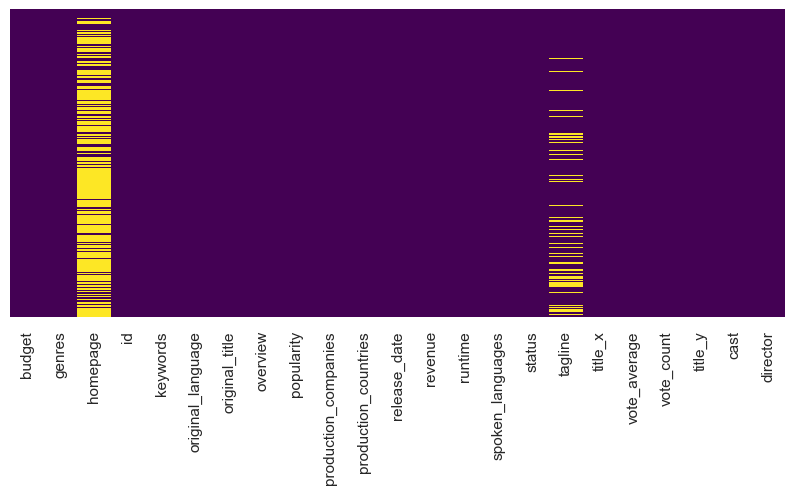

In [142]:
sns.heatmap(movies.isnull(),yticklabels=False, cbar=False, cmap='viridis')

Step 7: Dropping Null Values

In [143]:
movies = movies.dropna(subset=['director', 'runtime'])

In [144]:
movies = movies[movies['revenue'] > 100000]  
movies = movies[movies['budget'] > 1000]       
movies = movies[movies['budget'] <= 500000000] 
movies = movies[movies['revenue'] <= 3000000000] 

In [145]:
movies["revenue"] = movies["revenue"] / 1000000  
movies["budget"] = movies["budget"] / 1000000    

In [146]:
movies['release_date'] = pd.to_datetime(movies['release_date'], dayfirst=True, errors='coerce')
movies['release_month'] = movies['release_date'].dt.month
movies['release_DOW'] = movies['release_date'].dt.dayofweek

In [147]:
movies['release_month'].fillna(movies['release_month'].mode()[0], inplace=True)
movies['release_DOW'].fillna(movies['release_DOW'].mode()[0], inplace=True)

print(f"Final data shape: {movies.shape}")
print(f"Revenue range: ${movies['revenue'].min():.1f}M - ${movies['revenue'].max():.1f}M")
print(f"Budget range: ${movies['budget'].min():.1f}M - ${movies['budget'].max():.1f}M")

Final data shape: (3172, 25)
Revenue range: $0.1M - $2788.0M
Budget range: $0.0M - $380.0M


C:\Users\nvsha\AppData\Local\Temp\ipykernel_12908\4182088463.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies['release_month'].fillna(movies['release_month'].mode()[0], inplace=True)
C:\Users\nvsha\AppData\Local\Temp\ipykernel_12908\4182088463.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [148]:
print(f"Any zero revenues remaining: {(movies['revenue'] == 0).sum()}")
print(f"Any zero budgets remaining: {(movies['budget'] == 0).sum()}")

Any zero revenues remaining: 0
Any zero budgets remaining: 0


Step 8: Data Visualization

Text(0.5, 1.0, 'Boxplot of Runtime')

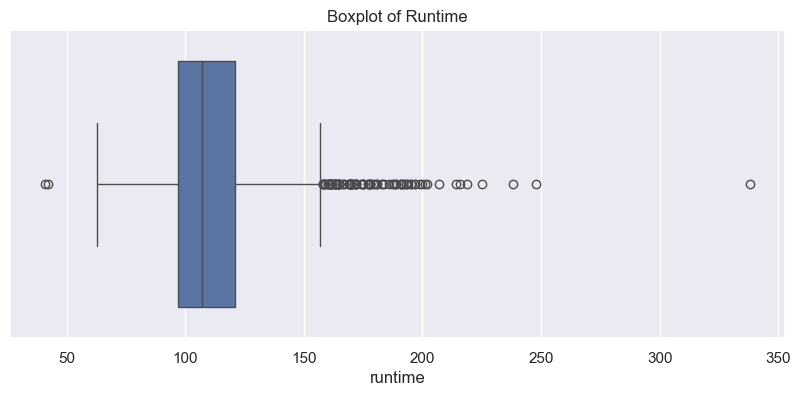

In [149]:
sns.boxplot(x=movies['runtime'])
plt.title('Boxplot of Runtime')

Text(0.5, 1.0, 'Boxplot of Revenue')

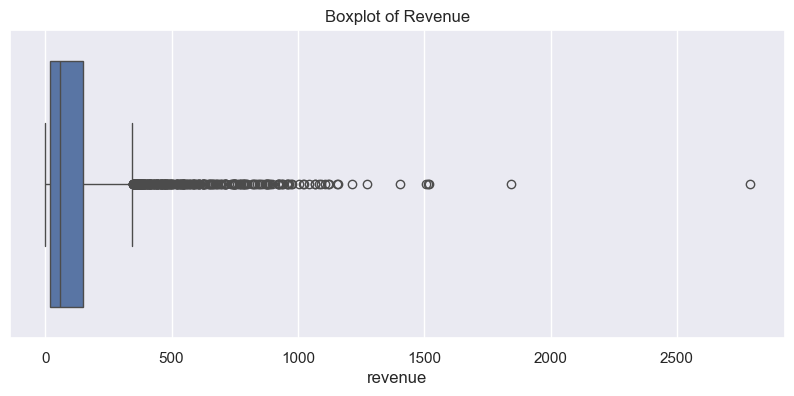

In [150]:
sns.boxplot(x=movies['revenue'])
plt.title('Boxplot of Revenue')

Text(0.5, 1.0, 'Boxplot of Budget')

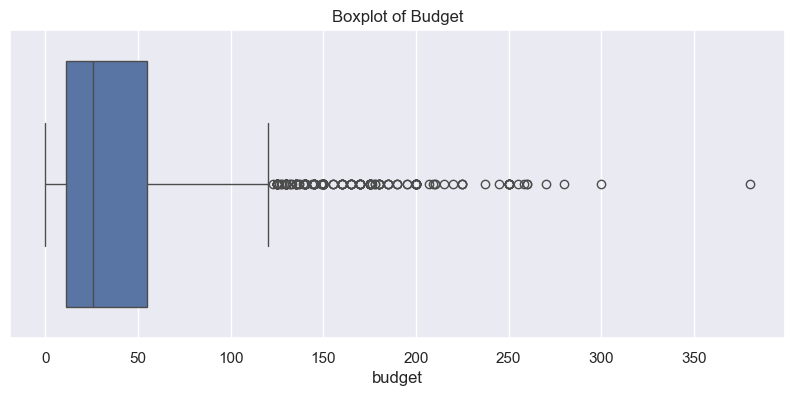

In [151]:
sns.boxplot(x=movies['budget'])
plt.title('Boxplot of Budget')


Step 9: Finding Coorelation between columns

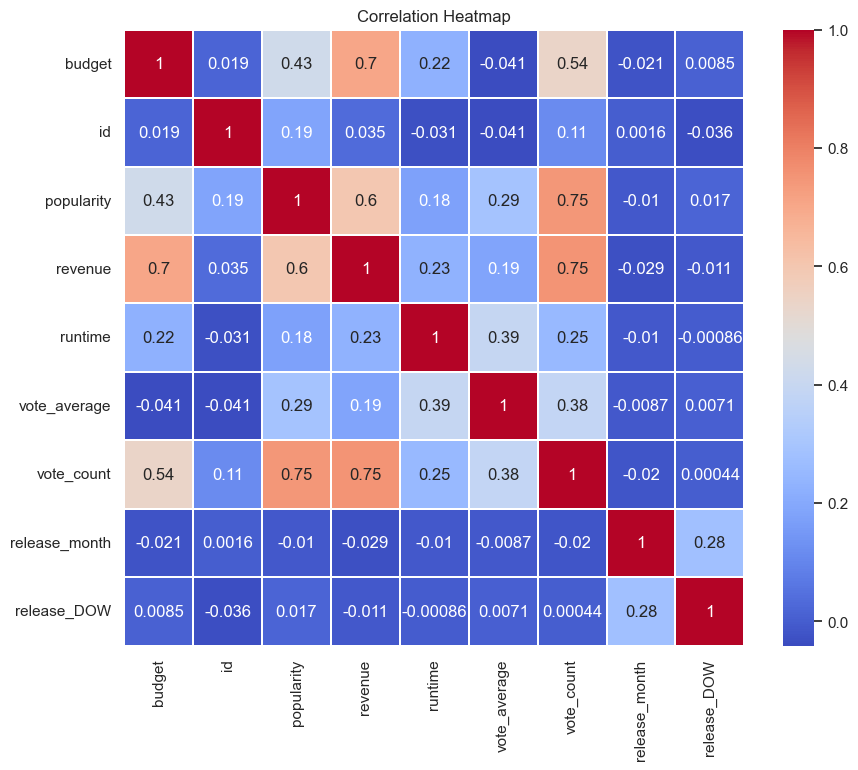

In [152]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    movies.corr(numeric_only=True),
    cmap='coolwarm',
    annot=True,
    linewidths=0.2
)
plt.title('Correlation Heatmap')
plt.show()

In [153]:
movies['log_revenue'] = np.log1p(movies['revenue'])
movies['log_budget'] = np.log1p(movies['budget'])

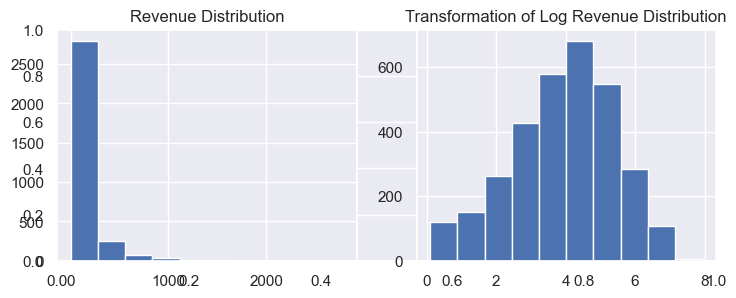

In [154]:
fig, ax = plt.subplots(figsize=(8.5, 3))
plt.subplot(1, 2, 1)
plt.hist(movies['revenue']);
plt.title('Revenue Distribution');
plt.subplot(1, 2, 2)
plt.hist(movies['log_revenue']);
plt.title('Transformation of Log Revenue Distribution');
plt.show()

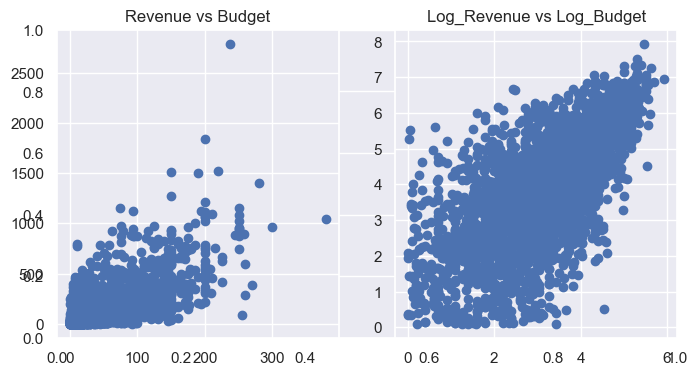

In [155]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(movies['budget'], movies['revenue']);
plt.title('Revenue vs Budget');
plt.subplot(1, 2, 2)
plt.scatter(movies['log_budget'], movies['log_revenue']);
plt.title('Log_Revenue vs Log_Budget');
plt.show()

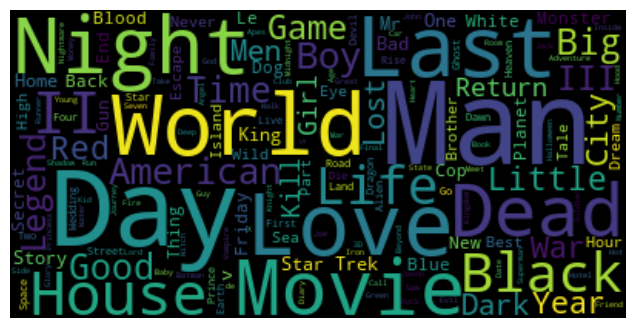

In [156]:
wordcloud = WordCloud().generate(movies.original_title.to_string())
sns.set(rc={'figure.figsize':(10, 4)})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Revenue by Homepage Presence')

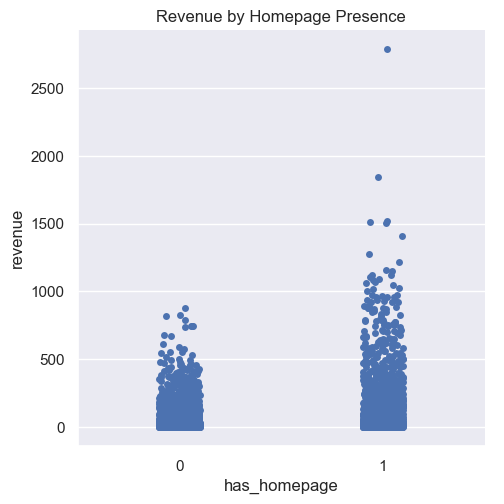

In [157]:
movies['has_homepage'] = 0
movies.loc[movies['homepage'].isnull() == False, 'has_homepage'] = 1
sns.catplot(x='has_homepage', y='revenue', data=movies)
plt.title('Revenue by Homepage Presence')

C:\Users\nvsha\AppData\Local\Temp\ipykernel_12908\2928806498.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax_joint.set_xticklabels(g.ax_joint.get_xticklabels(), rotation=90)


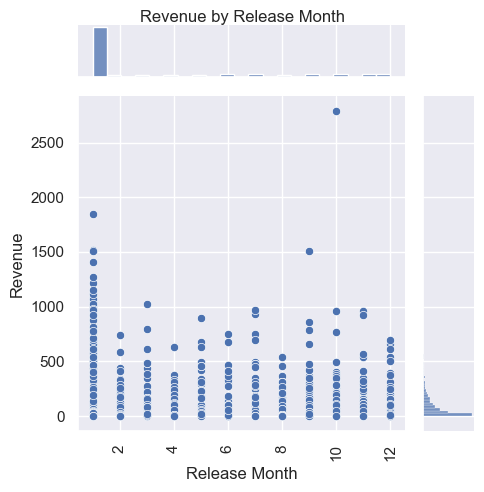

In [158]:
g = sns.jointplot(
    x='release_month',
    y='revenue',
    data=movies,
    kind='scatter',
    height=5
)

g.ax_joint.set_xticklabels(g.ax_joint.get_xticklabels(), rotation=90)
g.set_axis_labels('Release Month', 'Revenue')
g.fig.suptitle('Revenue by Release Month', fontsize=12)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95) 


In [159]:
movies['release_month'].fillna(movies['release_month'].mode()[0], inplace=True)
movies['release_DOW'].fillna(movies['release_DOW'].mode()[0], inplace=True)

C:\Users\nvsha\AppData\Local\Temp\ipykernel_12908\1795308210.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies['release_month'].fillna(movies['release_month'].mode()[0], inplace=True)
C:\Users\nvsha\AppData\Local\Temp\ipykernel_12908\1795308210.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

Step 10: Dropping Columns

In [160]:
movies_box = movies.drop(['homepage', 'keywords', 'original_title', 'overview', 'tagline', 'id', 'original_language','production_companies', 'production_countries', 'release_date', 'spoken_languages', 'status', 'title_x', 'title_y', 'cast' ], axis=1)

In [161]:
movies_box.isnull().sum()

budget           0
genres           0
popularity       0
revenue          0
runtime          0
vote_average     0
vote_count       0
director         0
release_month    0
release_DOW      0
log_revenue      0
log_budget       0
has_homepage     0
dtype: int64

Step 11: Label Encoding

In [162]:
mapping_dict = {}
category_col = ["director", "genres"]
for col in category_col:
    le = LabelEncoder()
    movies_box[col] = le.fit_transform(movies_box[col].astype(str)) 
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    mapping_dict[col] = le_name_mapping
    print(f"{col} mapping:", le_name_mapping)

director mapping: {'Abel Ferrara': np.int64(0), 'Adam Marcus': np.int64(1), 'Adam McKay': np.int64(2), 'Adam Rapp': np.int64(3), 'Adam Rifkin': np.int64(4), 'Adam Shankman': np.int64(5), 'Adrian Lyne': np.int64(6), 'Adrienne Shelly': np.int64(7), 'Agnieszka Wojtowicz-Vosloo': np.int64(8), 'Agustín Díaz Yanes': np.int64(9), 'Akira Kurosawa': np.int64(10), 'Akiva Goldsman': np.int64(11), 'Akiva Schaffer': np.int64(12), 'Al Silliman Jr.': np.int64(13), 'Alan J. Pakula': np.int64(14), 'Alan Parker': np.int64(15), 'Alan Poul': np.int64(16), 'Alan Shapiro': np.int64(17), 'Alan Taylor': np.int64(18), 'Albert Hughes': np.int64(19), 'Alejandro Agresti': np.int64(20), 'Alejandro Amenábar': np.int64(21), 'Alejandro González Iñárritu': np.int64(22), 'Alejandro Monteverde': np.int64(23), 'Aleksey German': np.int64(24), 'Alex Cox': np.int64(25), 'Alex Garland': np.int64(26), 'Alex Gibney': np.int64(27), 'Alex Kendrick': np.int64(28), 'Alex Proyas': np.int64(29), 'Alex Rivera': np.int64(30), 'Alexand

Step 12: Splitting the Dataset into Dependent and Independent variable.

In [163]:
features = ['budget', 'genres', 'popularity', 'runtime', 'vote_average', 
            'vote_count', 'director', 'release_month', 'release_DOW', 'has_homepage']

x = movies_box[features] 
y = movies_box['revenue']  

Step 13: Feature Scaling

In [164]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

Step 14: Split the dataset into Train set and Test set

In [165]:
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y, test_size=0.2, random_state=42
)

Step 15: Model Building by Train and Test the Model using Linear Regression

In [166]:
model = LinearRegression()
model.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Step 16: Model Evaluation

MAE: $65.83 million
RMSE: $132.79 million
R² Score: 0.6677
MAPE: 302.58%
budget: 76.9067
genres: -1.6299
popularity: 19.0215
runtime: -0.9487
vote_average: 1.3597
vote_count: 76.1234
director: 0.7547
release_month: -1.8430
release_DOW: -2.6766
has_homepage: 0.9873


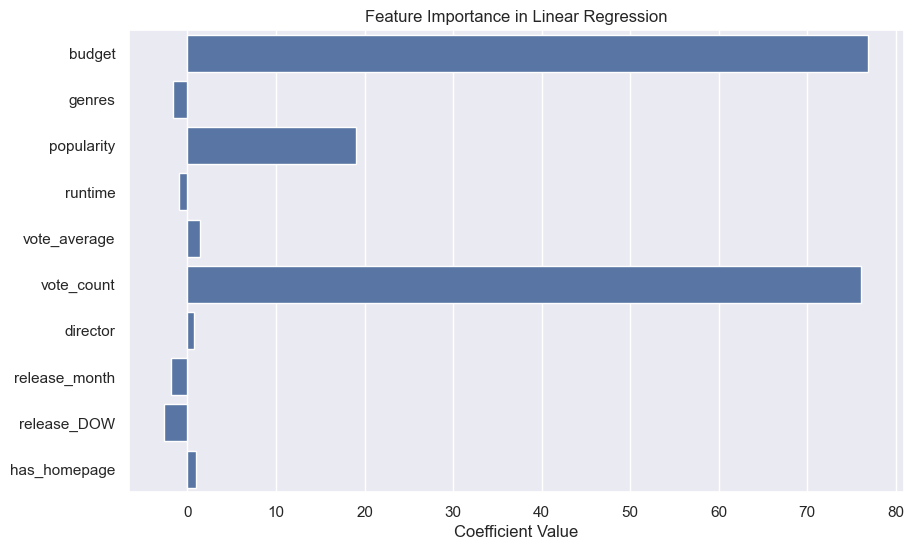

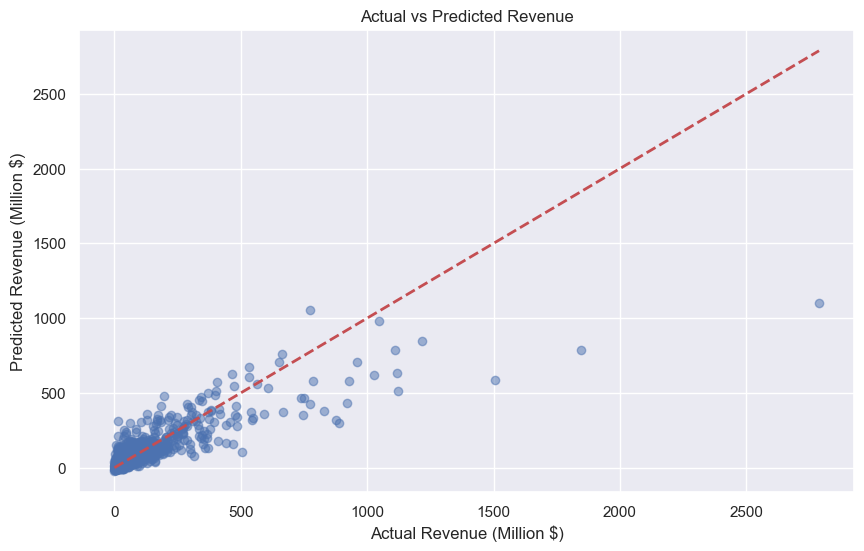

In [167]:
y_pred = model.predict(x_test)  

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-8  
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: ${mae:.2f} million")
print(f"RMSE: ${rmse:.2f} million")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

importance = model.coef_
for name, coef in zip(features, importance):
    print(f"{name}: {coef:.4f}")

plt.figure(figsize=(10, 6))
sns.barplot(x=importance, y=features)
plt.title("Feature Importance in Linear Regression")
plt.xlabel("Coefficient Value")
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue (Million $)')
plt.ylabel('Predicted Revenue (Million $)')
plt.title('Actual vs Predicted Revenue')
plt.show()


budget: 76.9067
genres: -1.6299
popularity: 19.0215
runtime: -0.9487
vote_average: 1.3597
vote_count: 76.1234
director: 0.7547
release_month: -1.8430
release_DOW: -2.6766
has_homepage: 0.9873


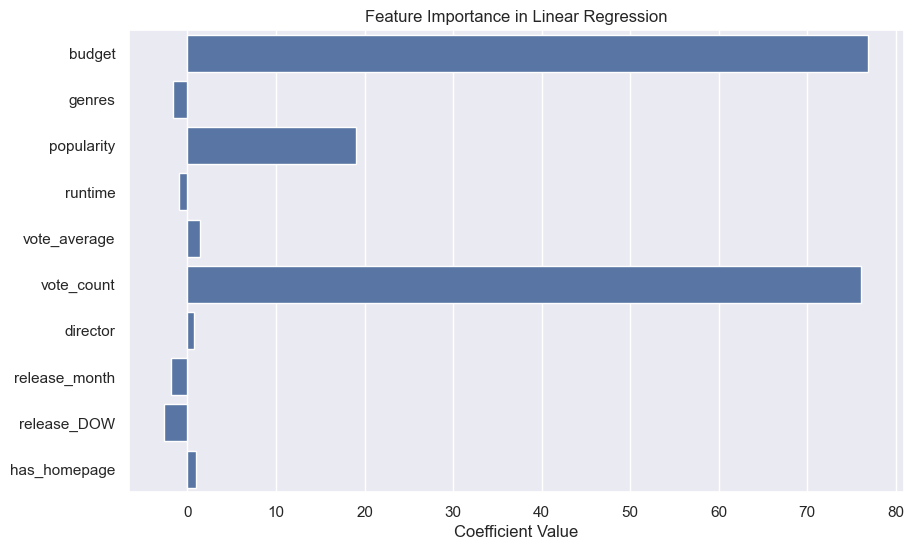

In [168]:
importance = model.coef_
for name, coef in zip(features, importance):
    print(f"{name}: {coef:.4f}")

plt.figure(figsize=(10, 6))
sns.barplot(x=importance, y=features)
plt.title("Feature Importance in Linear Regression")
plt.xlabel("Coefficient Value")
plt.show()

Step 17: Save the Model

In [169]:
with open('model_movies.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('scaler_movies.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(mapping_dict, f)

print("Model and components saved successfully!")

print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"Mean Absolute Error: ${mae:.2f} million")
print(f"Root Mean Square Error: ${rmse:.2f} million") 
print(f"R² Score: {r2:.4f} ({r2*100:.1f}% variance explained)")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print("="*50)

Model and components saved successfully!

MODEL PERFORMANCE SUMMARY
Mean Absolute Error: $65.83 million
Root Mean Square Error: $132.79 million
R² Score: 0.6677 (66.8% variance explained)
Mean Absolute Percentage Error: 302.58%


Step 18: Predicting the Output using the Model

In [170]:
def predict_revenue(budget, genres_name, popularity, runtime, vote_average, 
                   vote_count, director_name, release_month, release_DOW, has_homepage):

    model = pickle.load(open('model_movies.pkl', 'rb'))
    scaler = pickle.load(open('scaler_movies.pkl', 'rb'))
    label_encoders = pickle.load(open('label_encoders.pkl', 'rb'))
    
    if genres_name in label_encoders['genres']:
        genres_encoded = label_encoders['genres'][genres_name]
    else:
        genres_encoded = 0 
        
    if director_name in label_encoders['director']:
        director_encoded = label_encoders['director'][director_name]
    else:
        director_encoded = 0  
    
    input_features = [[budget, genres_encoded, popularity, runtime, vote_average, 
                      vote_count, director_encoded, release_month, release_DOW, has_homepage]]
    
    input_scaled = scaler.transform(input_features)
    
    predicted_revenue = model.predict(input_scaled)
    
    return predicted_revenue[0]

In [171]:
try:
    predicted_revenue = predict_revenue(
        budget=50,        
        genres_name="Action",
        popularity=20.0,     
        runtime=120,    
        vote_average=7.0,  
        vote_count=1000,  
        director_name="Unknown", 
        release_month=7, 
        release_DOW=5,
        has_homepage=1       
    )
    print(f"\nExample Prediction:")
    print(f"Predicted Revenue: ${predicted_revenue:.2f} million")
except Exception as e:
    print(f"Prediction error: {e}")
    print("This might be due to unknown categories in the encoder")


Example Prediction:
Predicted Revenue: $129.33 million


c:\Users\nvsha\Desktop\movie_box_office_predictior\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
